In [55]:
import os
import spacy
from spacy.tokens import Doc
import sddk
import pandas as pd
import re
import matplotlib.pyplot as plt
import json
import shutil

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

In [2]:
# load the language model (see the previous script)
nlp = spacy.load('la_core_web_lg')

In [3]:
# setup communication with gsheet "noscemus_overview
# to make this work, you need your ServiceAccountKey.json file located somewhere and to point out to it
# I have it in the data folder and in the .gitignore file, what makes it invisible to others; you can make the same
file_data = json.load(open("../data/ServiceAccountsKey.json"))
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)

noscemus_gs = gc.open_by_url("https://docs.google.com/spreadsheets/d/1ekf9RBfd4yqy0p0IWJ4SDk1kUT70hnoIVX1H6KPdIts/edit?usp=sharing")

# Explore metadata

In [4]:
ids_filenames_df = pd.read_csv("../data/ids_filenames_df.csv")
ids_filenames_df.head(5)

,Unnamed: 0,id,filenames_list
0,0,1031760,"['Bacon,_Francis_-_Instauratio_magna__London_1..."
1,1,1085290,"['Linden,_Johannes_Antonides_van_der_-_Lindeni..."
2,2,1285853,"['de_Conde,_Ioannes_Baptista_-_Aphorismi_seu_a..."
3,3,1285854,"['van_Poort,_Henricus_-_Hippocratis_Aphorismi_..."
4,4,1285855,"['Hippocrates_&_Denisot,_Gérard_-_Hippocratis_..."


In [5]:
ids_filenames_df["id"].dtype

dtype('int64')

In [6]:
metadata_table = pd.read_csv("../data/metadata_table.csv")

In [7]:
len(metadata_table)

994

In [8]:
metadata_table.head(20)

,Author,Full title,In,Year,Place,Publisher/Printer,Era,Form/Genre,Discipline/Content,Original,Digital sourcebook,Description,References,Cited in,How to cite this entry,Internal notes,Of interest to,Transkribus text available,Written by,Library and Signature
0,"Pardies, Ignace Gaston",A Latin Letter written to the Publisher April ...,Philosophical Transactions of the Royal Societ...,1672,London,Martyn,17th century,"Letter, Review",Physics,A Latin Letter(JSTOR),607720,"In Feburary of 1672,Isaac Newtonpublished his ...","Harmon; Gross 2007, 22–5","Pardies, Ignace Gaston‎(← links)Mr. Newtons Le...","Pardies, Ignace Gaston:A Latin Letter containi...",RECENSIO,NaN,Yes,IT,NaN
1,"Scheuchzer, Johann Jakob","Acarnania sive Relatio eorum, quae hactenus el...","ΟΥΡΕΣΙΦΟΙΤΗΣ (Ouresiphoites) Helveticus, 609–35",1723,Leiden,"van der Aa, Pieter",18th century,"Biography, Bibliography","Mathematics, Physics, Geography/Cartography, M...","Acarnania (1st edition), inMiscellanea Lipsien...",605919(in:ΟΥΡΕΣΙΦΟΙΤΗΣ Helveticus),The remarknunc primum editain the title of thi...,NaN,Charta invitatoria‎(← links)ΟΥΡΕΣΙΦΟΙΤΗΣ (Oure...,"Scheuchzer, Johann Jakob:Acarnania, in: Noscem...",NaN,MK,Yes,MK,NaN
2,"Morabito, Giuseppe",Ad astronautas Americanos carmen Iosephi Morab...,Fons pacis. Nova aetas. Ad astronautas America...,1969,Amsterdam,Nord-Hollandsche Uitgevers Maatschapij,After 1800,Panegyric poem,Astronomy/Astrology/Cosmography,Download PDF(Transcript),not available,"As late as the 20th century, the imagination o...","Giustiniani 1979, 108 (list of award-winning p...","Morabito, Giuseppe‎(← links)","Morabito, Giuseppe:Ad astronautas Americanos, ...","The Earthrise picture and ""Please be informed ...",IT,NaN,IT,NaN
3,"Addison, Joseph",Ad insignissimum virum dominum Thomam Burnettu...,"Examen poeticum duplex, sive, Musarum anglican...",1698,London,Richard Wellington I.,17th century,Panegyric poem,Meteorology/Earth sciences,Ad Burnettum sacrae theoriae telluris auctorem...,769230,"To the Very Famous Mr. Thomas Burnet, Author o...",NaN,"Addison, Joseph‎(← links)Nova philosophia vete...","Addison, Joseph:Ad Burnettum sacrae theoriae t...",NaN,"MK, IT",Yes,MK,NaN
4,"Lipsius, Justus",Ad Clusii nomen lusus,"L'Ecluse, Charles de, Rariorum aliquot stirpiu...",1583,Antwerp,Plantin,16th century,Panegyric poem,"Biology, Medicine, Other (see description)",Ad Clusii nomen lusus(Biblioteca Digital Real ...,749217,This witty epigram by the famous Flemish philo...,"Ogilvie 2011, 28-9",Rariorum stirpium per Pannoniam et Austriam ob...,"Lipsius, Justus:Ad Clusii nomen lusus, in: Nos...","Possibly, this epigram could be found in Lipsi...",IT,Yes,IT,NaN
5,"Owen, John",Ad Dominum Gilbertum,Epigrammatum libri tres. Auctore Ioanne Owen B...,1606,London,"Windet, John, Waterson, Simon",17th century,Other (see description),Astronomy/Astrology/Cosmography,3rd edition (Amberg 1608)(Google Books)Digital...,"900767(3rd edition, Amberg 1608)",John Owen was the most popular Anglo-Latin epi...,Martyn 1976–1978;Durand 2016(editions)Jansen 2009,"Owen, John‎(← links)An terra moveatur‎(← links)","Owen, John:Ad Gilbertum, in: Noscemus Wiki, UR...",First edition in sharefolder.The epigram was a...,"JL, IT",Yes,IT,NaN
6,"Costus, Petrus",Petrus Costus ad Gulielmum Rondeletium medicum...,"Aquatilium historia, vol. 1, fol. α3r",1554,Lyon,Bonhomme,16th century,Panegyric poem,Biology,"Aquatilium historia, vol. 1(Google Books)",748052,The first volume of Rondelet'sAquatilium histo...,NaN,"Aquatilium historia‎(← links)Costus, Petrus‎(←...","Costus, Petrus:Ad Gulielmum Rondeletium, in: N...",NaN,MK,Yes,MK,NaN
7,"Acidalius, Valens","Ad Iordanum Brunum Nolanum, Italum","Poematum Iani Lernutii, Iani Gulielmi, Valenti...",1603,"Liegnitz, Wrocław","Albert, David",17th century,Panegyric poem,Astronomy/Astrology/Cosmography,Ad Iordanum Brunum (1603)(CAMENA)Ad Iordanum B...,801745,Most of the posthumously edited epigrams of th...,"Kühlmann 1979, 152–53","Acidalius, Valens‎(← links)","Acidalius, Valens:Ad 

In [9]:
metadata_table["Digital sourcebook"].tolist()[:100]

['607720',
 '605919(in:ΟΥΡΕΣΙΦΟΙΤΗΣ Helveticus)',
 'not available',
 '769230',
 '749217',
 '900767(3rd edition, Amberg 1608)',
 '748052',
 '801745',
 '900763',
 '801744',
 'not available',
 '653295',
 '775165',
 '807622(Vol. 1)807623(Vol. 2)807624(Vol. 3)',
 '683332',
 '597737',
 '616642',
 '616643(Basel 1561)',
 '899971',
 '699869',
 'not available',
 '913057(vol. 1)913059(vol. 2)913060(vol. 3)913061(vol. 4)913062(vol. 5)913063(vol. 6)913064(vol. 7)913065(vol. 8)913066(vol. 9)913058(vol. 10)',
 '807407',
 '750210',
 '862096',
 '691442',
 '801743',
 '696410',
 '598518',
 '689823',
 'not available',
 '807625',
 '900764',
 '689826',
 '658382',
 '643408',
 '900765',
 '801742',
 '604274(Amsterdam 1748)',
 '691681(Vol. 1)691682(Vol. 2)',
 '1479057',
 '1461594',
 '713325',
 '616640',
 '1285853(Brussels 1647)',
 '801750',
 'not available',
 '708107',
 '708106',
 '782232',
 '652471',
 '807329',
 '652468',
 '705022',
 '901017',
 '831513',
 '699868',
 '906157(Târgu Mureș 1832)',
 '748052(Vol. 1)

In [10]:
id_text = metadata_table["Digital sourcebook"].tolist()[21]
id_text

'913057(vol. 1)913059(vol. 2)913060(vol. 3)913061(vol. 4)913062(vol. 5)913063(vol. 6)913064(vol. 7)913065(vol. 8)913066(vol. 9)913058(vol. 10)'

In [11]:
def clean_id(id_text):
    try:
        ids = [int(id) for id in re.findall("\d{5,8}", id_text)]
    except:
        ids = []
    return ids

In [12]:
clean_id(id_text)

[913057,
 913059,
 913060,
 913061,
 913062,
 913063,
 913064,
 913065,
 913066,
 913058]

In [13]:
metadata_table["ids"] = metadata_table["Digital sourcebook"].apply(clean_id)

In [14]:
metadata_table.head(10)

,Author,Full title,In,Year,Place,Publisher/Printer,Era,Form/Genre,Discipline/Content,Original,...,Description,References,Cited in,How to cite this entry,Internal notes,Of interest to,Transkribus text available,Written by,Library and Signature,ids
0,"Pardies, Ignace Gaston",A Latin Letter written to the Publisher April ...,Philosophical Transactions of the Royal Societ...,1672,London,Martyn,17th century,"Letter, Review",Physics,A Latin Letter(JSTOR),...,"In Feburary of 1672,Isaac Newtonpublished his ...","Harmon; Gross 2007, 22–5","Pardies, Ignace Gaston‎(← links)Mr. Newtons Le...","Pardies, Ignace Gaston:A Latin Letter containi...",RECENSIO,NaN,Yes,IT,NaN,[607720]
1,"Scheuchzer, Johann Jakob","Acarnania sive Relatio eorum, quae hactenus el...","ΟΥΡΕΣΙΦΟΙΤΗΣ (Ouresiphoites) Helveticus, 609–35",1723,Leiden,"van der Aa, Pieter",18th century,"Biography, Bibliography","Mathematics, Physics, Geography/Cartography, M...","Acarnania (1st edition), inMiscellanea Lipsien...",...,The remarknunc primum editain the title of thi...,NaN,Charta invitatoria‎(← links)ΟΥΡΕΣΙΦΟΙΤΗΣ (Oure...,"Scheuchzer, Johann Jakob:Acarnania, in: Noscem...",NaN,MK,Yes,MK,NaN,[605919]
2,"Morabito, Giuseppe",Ad astronautas Americanos carmen Iosephi Morab...,Fons pacis. Nova aetas. Ad astronautas America...,1969,Amsterdam,Nord-Hollandsche Uitgevers Maatschapij,After 1800,Panegyric poem,Astronomy/Astrology/Cosmography,Download PDF(Transcript),...,"As late as the 20th century, the imagination o...","Giustiniani 1979, 108 (list of award-winning p...","Morabito, Giuseppe‎(← links)","Morabito, Giuseppe:Ad astronautas Americanos, ...","The Earthrise picture and ""Please be informed ...",IT,NaN,IT,NaN,[]
3,"Addison, Joseph",Ad insignissimum virum dominum Thomam Burnettu...,"Examen poeticum duplex, sive, Musarum anglican...",1698,London,Richard Wellington I.,17th century,Panegyric poem,Meteorology/Earth sciences,Ad Burnettum sacrae theoriae telluris auctorem...,...,"To the Very Famous Mr. Thomas Burnet, Author o...",NaN,"Addison, Joseph‎(← links)Nova philosophia vete...","Addison, Joseph:Ad Burnettum sacrae theoriae t...",NaN,"MK, IT",Yes,MK,NaN,[769230]
4,"Lipsius, Justus",Ad Clusii nomen lusus,"L'Ecluse, Charles de, Rariorum aliquot stirpiu...",1583,Antwerp,Plantin,16th century,Panegyric poem,"Biology, Medicine, Other (see description)",Ad Clusii nomen lusus(Biblioteca Digital Real ...,...,This witty epigram by the famous Flemish philo...,"Ogilvie 2011, 28-9",Rariorum stirpium per Pannoniam et Austriam ob...,"Lipsius, Justus:Ad Clusii nomen lusus, in: Nos...","Possibly, this epigram could be found in Lipsi...",IT,Yes,IT,NaN,[749217]
5,"Owen, John",Ad Dominum Gilbertum,Epigrammatum libri tres. Auctore Ioanne Owen B...,1606,London,"Windet, John, Waterson, Simon",17th century,Other (see description),Astronomy/Astrology/Cosmography,3rd edition (Amberg 1608)(Google Books)Digital...,...,John Owen was the most popular Anglo-Latin epi...,Martyn 1976–1978;Durand 2016(editions)Jansen 2009,"Owen, John‎(← links)An terra moveatur‎(← links)","Owen, John:Ad Gilbertum, in: Noscemus Wiki, UR...",First edition in sharefolder.The epigram was a...,"JL, IT",Yes,IT,NaN,[900767]
6,"Costus, Petrus",Petrus Costus ad Gulielmum Rondeletium medicum...,"Aquatilium historia, vol. 1, fol. α3r",1554,Lyon,Bonhomme,16th century,Panegyric poem,Biology,"Aquatilium historia, vol. 1(Google Books)",...,The first volume of Rondelet'sAquatilium histo...,NaN,"Aquatilium historia‎(← links)Costus, Petrus‎(←...","Costus, Petrus:Ad Gulielmum Rondeletium, in: N...",NaN,MK,Yes,MK,NaN,[748052]
7,"Acidalius, Valens","Ad Iordanum Brunum Nolanum, Italum","Poematum Iani Lernutii, Iani Gulielmi, Valenti...",1603,"Liegnitz, Wrocław","Albert, David",17th century,Panegyric poem,Astronomy/Astrology/Cosmography,Ad Iordanum Brunum (1603)(CAMENA)Ad Iordanum B...,...,Most of the posthumously edited epigrams of th...,"Kühlmann 1979, 152–53","Acidalius, Valens‎(← links)","Acidalius, Valens:Ad Iordanum Brunum, in: Nosc...",Kühlmann mu

In [15]:
metadata_table.iloc[0].to_dict()

{'Author': 'Pardies, Ignace Gaston',
 'Full title': 'A Latin Letter written to the Publisher April 9. 1672. n. st. by Ignatius Gaston Pardies P. Prof. of the Mathematicks in the Parisian Colledge of Clermont, containing some Animadversions upon Mr. Isaac Newton, Prof. of the Mathematicks in the University of Cambridge, his Theory of Light, printed in N.° 80.',
 'In': 'Philosophical Transactions of the Royal Society 7/84, 4087–90',
 'Year': '1672',
 'Place': 'London',
 'Publisher/Printer': 'Martyn',
 'Era': '17th century',
 'Form/Genre': 'Letter, Review',
 'Discipline/Content': 'Physics',
 'Original': 'A Latin Letter(JSTOR)',
 'Digital sourcebook': '607720',
 'Description': 'In Feburary of 1672,Isaac Newtonpublished his groundbreaking new theory about light and colours, in anEnglish paperin the 80th issue of thePhilosophical Transactions(p. 3075–87). In this scientific paper styled as a letter, Newton accounts how through his experiments with glass prisms, he came to the conclusion that

In [16]:
metadata_table_long = []
for n in range(len(metadata_table)):
    df_row_dict = metadata_table.iloc[n].to_dict()
    for oneid in df_row_dict["ids"]:
        df_row_dict["id"] = oneid
        metadata_table_long.append(df_row_dict)
        df_row_dict = df_row_dict.copy()

In [17]:
metadata_table_long = pd.DataFrame(metadata_table_long)
metadata_table_long.head(20)

,Author,Full title,In,Year,Place,Publisher/Printer,Era,Form/Genre,Discipline/Content,Original,...,References,Cited in,How to cite this entry,Internal notes,Of interest to,Transkribus text available,Written by,Library and Signature,ids,id
0,"Pardies, Ignace Gaston",A Latin Letter written to the Publisher April ...,Philosophical Transactions of the Royal Societ...,1672,London,Martyn,17th century,"Letter, Review",Physics,A Latin Letter(JSTOR),...,"Harmon; Gross 2007, 22–5","Pardies, Ignace Gaston‎(← links)Mr. Newtons Le...","Pardies, Ignace Gaston:A Latin Letter containi...",RECENSIO,NaN,Yes,IT,NaN,[607720],607720
1,"Scheuchzer, Johann Jakob","Acarnania sive Relatio eorum, quae hactenus el...","ΟΥΡΕΣΙΦΟΙΤΗΣ (Ouresiphoites) Helveticus, 609–35",1723,Leiden,"van der Aa, Pieter",18th century,"Biography, Bibliography","Mathematics, Physics, Geography/Cartography, M...","Acarnania (1st edition), inMiscellanea Lipsien...",...,NaN,Charta invitatoria‎(← links)ΟΥΡΕΣΙΦΟΙΤΗΣ (Oure...,"Scheuchzer, Johann Jakob:Acarnania, in: Noscem...",NaN,MK,Yes,MK,NaN,[605919],605919
2,"Addison, Joseph",Ad insignissimum virum dominum Thomam Burnettu...,"Examen poeticum duplex, sive, Musarum anglican...",1698,London,Richard Wellington I.,17th century,Panegyric poem,Meteorology/Earth sciences,Ad Burnettum sacrae theoriae telluris auctorem...,...,NaN,"Addison, Joseph‎(← links)Nova philosophia vete...","Addison, Joseph:Ad Burnettum sacrae theoriae t...",NaN,"MK, IT",Yes,MK,NaN,[769230],769230
3,"Lipsius, Justus",Ad Clusii nomen lusus,"L'Ecluse, Charles de, Rariorum aliquot stirpiu...",1583,Antwerp,Plantin,16th century,Panegyric poem,"Biology, Medicine, Other (see description)",Ad Clusii nomen lusus(Biblioteca Digital Real ...,...,"Ogilvie 2011, 28-9",Rariorum stirpium per Pannoniam et Austriam ob...,"Lipsius, Justus:Ad Clusii nomen lusus, in: Nos...","Possibly, this epigram could be found in Lipsi...",IT,Yes,IT,NaN,[749217],749217
4,"Owen, John",Ad Dominum Gilbertum,Epigrammatum libri tres. Auctore Ioanne Owen B...,1606,London,"Windet, John, Waterson, Simon",17th century,Other (see description),Astronomy/Astrology/Cosmography,3rd edition (Amberg 1608)(Google Books)Digital...,...,Martyn 1976–1978;Durand 2016(editions)Jansen 2009,"Owen, John‎(← links)An terra moveatur‎(← links)","Owen, John:Ad Gilbertum, in: Noscemus Wiki, UR...",First edition in sharefolder.The epigram was a...,"JL, IT",Yes,IT,NaN,[900767],900767
5,"Costus, Petrus",Petrus Costus ad Gulielmum Rondeletium medicum...,"Aquatilium historia, vol. 1, fol. α3r",1554,Lyon,Bonhomme,16th century,Panegyric poem,Biology,"Aquatilium historia, vol. 1(Google Books)",...,NaN,"Aquatilium historia‎(← links)Costus, Petrus‎(←...","Costus, Petrus:Ad Gulielmum Rondeletium, in: N...",NaN,MK,Yes,MK,NaN,[748052],748052
6,"Acidalius, Valens","Ad Iordanum Brunum Nolanum, Italum","Poematum Iani Lernutii, Iani Gulielmi, Valenti...",1603,"Liegnitz, Wrocław","Albert, David",17th century,Panegyric poem,Astronomy/Astrology/Cosmography,Ad Iordanum Brunum (1603)(CAMENA)Ad Iordanum B...,...,"Kühlmann 1979, 152–53","Acidalius, Valens‎(← links)","Acidalius, Valens:Ad Iordanum Brunum, in: Nosc...",Kühlmann must have overlooked the poem in the ...,"MK, IT",Yes,MK,NaN,[801745],801745
7,"Paulinus, Fabius","Ad clarissimum virum Laurentium Massam, sereni...","Avicennae, Arabum medicorum principis, ex Gera...",1595,Venice,I Giunti,16th century,Panegyric poem,Medicine,Ad Laurentium Massam pro Avicenna ode(Google B...,...,"Siraisi 1987, 143","Paulinus, Fabius‎(← links)","Paulinus, Fabius:Ad Laurentium Massam pro Avic...","On the title page of the edition, the many acc...",MK,Yes,MK,NaN,[900763],900763
8,"Sands, Patrick",Ad lectorem trigonometriae studiosum,Mirifici logarithmorum canonis descriptioeiusq...,1614,Edinburgh,Andro Hart,17th century,Panegyric poem,Mathematics,Ad lectorem trigonometriae studiosum(Google Bo...,...,McOmish 2017,Mirifici logarithmorum canonis descriptio‎(← l...,"Sands, Patrick:Ad lectorem trigonometriae stud...",Sands 

In [18]:
for date in metadata_table_long["Year"]:
    try:
        int(date)
    except:
        print(date)

[c. 1490]
1651; 1665
1749–1790
1749–1790
1749–1790
1749–1790
1749–1790
1749–1790
1749–1790
1749–1790
1749–1790
1749–1790
1675–1679
1754–1770
1754–1770
1817–1826
1554–1555
1554–1555
[1557]
1771–1772
1545 (title page); 1544 (last page)
[1476]
1498 [1554]
[1727]
[1524]
1495 more Veneto / 1496
nan
1554 [1507]
1579 [1576]
1659–1661
[1500]
1612 [1591]
1665 [1616]
1743 [1700; 1713]
nan
1680–1681
1680–1681
1588; 1603 (2nd edition)
1588; 1603 (2nd edition)
1540 [ca. 1484–1487]
1495–1497
1532/1534
1714 [1754]
1576 [editio princeps: 1492]
1500–1504
nan
[1475]
[1700]
1773–1775
1773–1775
1773–1775
1773–1775
1773–1775
1773–1775
1618 (books 1–3); 1620 (book 4); 1621 (books 5–7)
[1617]
1747–1769
Antwerp
1736 [date on title page; in fact, 1735]
1736 [date on title page; in fact, 1735]
1659–1661
1741–1750
1741–1750
1741–1750
1741–1750
1741–1750
1741–1750
1741–1750
1741–1750
1530–1536
1530–1536
1530–1536
1551; 1554; 1555; 1558
1551; 1554; 1555; 1558
1551; 1554; 1555; 1558
1551; 1554; 1555; 1558
1779–1781

In [19]:
dates_str = "1718; 1720; 1727; 1729; 1732; 1737; 1739; 1739; 1740"
sorted([int(date) for date in re.findall("\d{4}", dates_str)])

[1718, 1720, 1727, 1729, 1732, 1737, 1739, 1739, 1740]

In [20]:
dates_min_max = []
for date_str in metadata_table_long["Year"]:
    try:
        date_min = int(date_str)
        date_max = date_min
    except:
        try:   
            dates_int = sorted([int(date) for date in re.findall("\d{4}", date_str)])
            date_min = dates_int[0]
            date_max = dates_int[-1]
        except:
            date_min = None
            date_max = None
    dates_min_max.append((date_min, date_max))

In [21]:
dates_min_max[:50]

[(1672, 1672),
 (1723, 1723),
 (1698, 1698),
 (1583, 1583),
 (1606, 1606),
 (1554, 1554),
 (1603, 1603),
 (1595, 1595),
 (1614, 1614),
 (1615, 1615),
 (1620, 1620),
 (1648, 1648),
 (1648, 1648),
 (1648, 1648),
 (1591, 1591),
 (1597, 1597),
 (1572, 1572),
 (1561, 1561),
 (1490, 1490),
 (1651, 1665),
 (1749, 1790),
 (1749, 1790),
 (1749, 1790),
 (1749, 1790),
 (1749, 1790),
 (1749, 1790),
 (1749, 1790),
 (1749, 1790),
 (1749, 1790),
 (1749, 1790),
 (1712, 1712),
 (1720, 1720),
 (1654, 1654),
 (1723, 1723),
 (1651, 1651),
 (1666, 1666),
 (1675, 1679),
 (1666, 1666),
 (1611, 1611),
 (1580, 1580),
 (1683, 1683),
 (1533, 1533),
 (1787, 1787),
 (1631, 1631),
 (1614, 1614),
 (1747, 1747),
 (1754, 1770),
 (1754, 1770),
 (1817, 1826),
 (1738, 1738)]

In [22]:
metadata_table_long["date_min"] = [el[0] for el in dates_min_max]
metadata_table_long["date_max"] = [el[1] for el in dates_min_max]

In [23]:
metadata_table_long

,Author,Full title,In,Year,Place,Publisher/Printer,Era,Form/Genre,Discipline/Content,Original,...,How to cite this entry,Internal notes,Of interest to,Transkribus text available,Written by,Library and Signature,ids,id,date_min,date_max
0,"Pardies, Ignace Gaston",A Latin Letter written to the Publisher April ...,Philosophical Transactions of the Royal Societ...,1672,London,Martyn,17th century,"Letter, Review",Physics,A Latin Letter(JSTOR),...,"Pardies, Ignace Gaston:A Latin Letter containi...",RECENSIO,NaN,Yes,IT,NaN,[607720],607720,1672.0,1672.0
1,"Scheuchzer, Johann Jakob","Acarnania sive Relatio eorum, quae hactenus el...","ΟΥΡΕΣΙΦΟΙΤΗΣ (Ouresiphoites) Helveticus, 609–35",1723,Leiden,"van der Aa, Pieter",18th century,"Biography, Bibliography","Mathematics, Physics, Geography/Cartography, M...","Acarnania (1st edition), inMiscellanea Lipsien...",...,"Scheuchzer, Johann Jakob:Acarnania, in: Noscem...",NaN,MK,Yes,MK,NaN,[605919],605919,1723.0,1723.0
2,"Addison, Joseph",Ad insignissimum virum dominum Thomam Burnettu...,"Examen poeticum duplex, sive, Musarum anglican...",1698,London,Richard Wellington I.,17th century,Panegyric poem,Meteorology/Earth sciences,Ad Burnettum sacrae theoriae telluris auctorem...,...,"Addison, Joseph:Ad Burnettum sacrae theoriae t...",NaN,"MK, IT",Yes,MK,NaN,[769230],769230,1698.0,1698.0
3,"Lipsius, Justus",Ad Clusii nomen lusus,"L'Ecluse, Charles de, Rariorum aliquot stirpiu...",1583,Antwerp,Plantin,16th century,Panegyric poem,"Biology, Medicine, Other (see description)",Ad Clusii nomen lusus(Biblioteca Digital Real ...,...,"Lipsius, Justus:Ad Clusii nomen lusus, in: Nos...","Possibly, this epigram could be found in Lipsi...",IT,Yes,IT,NaN,[749217],749217,1583.0,1583.0
4,"Owen, John",Ad Dominum Gilbertum,Epigrammatum libri tres. Auctore Ioanne Owen B...,1606,London,"Windet, John, Waterson, Simon",17th century,Other (see description),Astronomy/Astrology/Cosmography,3rd edition (Amberg 1608)(Google Books)Digital...,...,"Owen, John:Ad Gilbertum, in: Noscemus Wiki, UR...",First edition in sharefolder.The epigram was a...,"JL, IT",Yes,IT,NaN,[900767],900767,1606.0,1606.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,"Scheuchzer, Johann Jakob",ΟΥΡΕΣΙΦΟΙΤΗΣ Helveticus sive itinera per Helve...,NaN,1723,Leiden,"van der Aa, Pieter",18th century,"Report, Bibliography","Geography/Cartography, Meteorology/Earth scien...",ΟΥΡΕΣΙΦΟΙΤΗΣ (Ouresiphoites) Helveticus(e-rara...,...,"Scheuchzer, Johann Jakob:ΟΥΡΕΣΙΦΟΙΤΗΣ (Ouresip...","Tomus primus (= Itinera 1702, 1703, 1704)Praef...",MK,Yes,MK,NaN,[605919],605919,1723.0,1723.0
1100,"Bauhin, Caspar",ΠΙΝΑΞ (Pinax) theatri botanici Caspari Bauhini...,NaN,1623,Basel,König,17th century,"Dictionary/Lexicon, Historia, Encyclopedic work",Biology,Pinax theatri botanici(e-rara.ch)Alternative l...,...,"Bauhin, Caspar:ΠΙΝΑΞ (Pinax) theatri botanici,...",NaN,"DB, MK",Yes,DB,NaN,[632437],632437,1623.0,1623.0
1101,"Colonna, Fabio",ΦΥΤΟΒΑΣΑΝΟΣ (Phytobasanos) sive plantarum aliq...,NaN,1592,Naples,"Salviani, Orazio",16th century,Historia,"Biology, Medicine",Phytobasanos(Biodiversity Heritage Library),...,"Colonna, Fabio:ΦΥΤΟΒΑΣΑΝΟΣ (Phytobasanos), in:...",NaN,DB,Yes,DB,NaN,[752863],752863,1592.0,1592.0
1102,"Scultetus, Johannes","ΧΕΙΡΟΠΛΟΘΗΚΗ seu domini Ioannis Sculteti, phys...",NaN,1655,Ulm,Kühn,17th century,"Monograph, Report, Other (see description)",Medicine,ΧΕΙΡΟΠΛΟΘΗΚΗ(Google Books)German translation (...,...,"Scultetus, Johannes:ΧΕΙΡΟΠΛΟΘΗΚΗ (Cheiroplothe...",Indications regarding the size of the instrume...,MK,Yes,MK,NaN,[918558],918558,1655.0,1655.0


In [24]:
ids_filenames_df.head(5)

,Unnamed: 0,id,filenames_list
0,0,1031760,"['Bacon,_Francis_-_Instauratio_magna__London_1..."
1,1,1085290,"['Linden,_Johannes_Antonides_van_der_-_Lindeni..."
2,2,1285853,"['de_Conde,_Ioannes_Baptista_-_Aphorismi_seu_a..."
3,3,1285854,"['van_Poort,_Henricus_-_Hippocratis_Aphorismi_..."
4,4,1285855,"['Hippocrates_&_Denisot,_Gérard_-_Hippocratis_..."


In [25]:
def get_filename(filenames_str):
    try:
        filenames = eval(filenames_str)
        filename = filenames[0]
    except:
        filename = ""
    return filename
ids_filenames_df["filename"] = ids_filenames_df["filenames_list"].apply(get_filename)

In [26]:
ids_filenames_df.head(10)

,Unnamed: 0,id,filenames_list,filename
0,0,1031760,"['Bacon,_Francis_-_Instauratio_magna__London_1...","Bacon,_Francis_-_Instauratio_magna__London_162..."
1,1,1085290,"['Linden,_Johannes_Antonides_van_der_-_Lindeni...","Linden,_Johannes_Antonides_van_der_-_Lindenius..."
2,2,1285853,"['de_Conde,_Ioannes_Baptista_-_Aphorismi_seu_a...","de_Conde,_Ioannes_Baptista_-_Aphorismi_seu_axi..."
3,3,1285854,"['van_Poort,_Henricus_-_Hippocratis_Aphorismi_...","van_Poort,_Henricus_-_Hippocratis_Aphorismi_me..."
4,4,1285855,"['Hippocrates_&_Denisot,_Gérard_-_Hippocratis_...","Hippocrates_&_Denisot,_Gérard_-_Hippocratis_Ap..."
5,5,1285856,"['Hippocrates_&_Berigardus,_Petrus_-_Hippocrat...","Hippocrates_&_Berigardus,_Petrus_-_Hippocratis..."
6,6,1365811,['Acta_literaria_Sueciae__Vol__1__Uppsala_[172...,Acta_literaria_Sueciae__Vol__1__Uppsala_[1723–...
7,7,1370560,"['Quensel,_Conrad_&_Eurodius,_Hans_-_De_lumine...","Quensel,_Conrad_&_Eurodius,_Hans_-_De_lumine_n..."
8,8,1378359,"['Celsius,_Anders_-_Observationes_de_lumine_Bo...","Celsius,_Anders_-_Observationes_de_lumine_Bore..."
9,9,1424044,"['Bacci,_Andrea_&_Gabelkover,_Wolfgang_-_De_mo...","Bacci,_Andrea_&_Gabelkover,_Wolfgang_-_De_mono..."


In [27]:
def get_year(filename):
    try:
        year = int(re.search("\d{4}", filename)[0])
    except:
        year = None    
    return year

ids_filenames_df["file_year"] = ids_filenames_df["filename"].apply(get_year)
ids_filenames_df.head(5)

,Unnamed: 0,id,filenames_list,filename,file_year
0,0,1031760,"['Bacon,_Francis_-_Instauratio_magna__London_1...","Bacon,_Francis_-_Instauratio_magna__London_162...",1620.0
1,1,1085290,"['Linden,_Johannes_Antonides_van_der_-_Lindeni...","Linden,_Johannes_Antonides_van_der_-_Lindenius...",1686.0
2,2,1285853,"['de_Conde,_Ioannes_Baptista_-_Aphorismi_seu_a...","de_Conde,_Ioannes_Baptista_-_Aphorismi_seu_axi...",1647.0
3,3,1285854,"['van_Poort,_Henricus_-_Hippocratis_Aphorismi_...","van_Poort,_Henricus_-_Hippocratis_Aphorismi_me...",1657.0
4,4,1285855,"['Hippocrates_&_Denisot,_Gérard_-_Hippocratis_...","Hippocrates_&_Denisot,_Gérard_-_Hippocratis_Ap...",1634.0


In [28]:
metadata_table_long = pd.merge(metadata_table_long, ids_filenames_df[["id", "filename", "file_year"]], on="id")
metadata_table_long.head(40)

,Author,Full title,In,Year,Place,Publisher/Printer,Era,Form/Genre,Discipline/Content,Original,...,Of interest to,Transkribus text available,Written by,Library and Signature,ids,id,date_min,date_max,filename,file_year
0,"Pardies, Ignace Gaston",A Latin Letter written to the Publisher April ...,Philosophical Transactions of the Royal Societ...,1672,London,Martyn,17th century,"Letter, Review",Physics,A Latin Letter(JSTOR),...,NaN,Yes,IT,NaN,[607720],607720,1672.0,1672.0,"Pardies,_Ignace_Gaston_-_A_Latin_Letter_contai...",1672.0
1,"Scheuchzer, Johann Jakob","Acarnania sive Relatio eorum, quae hactenus el...","ΟΥΡΕΣΙΦΟΙΤΗΣ (Ouresiphoites) Helveticus, 609–35",1723,Leiden,"van der Aa, Pieter",18th century,"Biography, Bibliography","Mathematics, Physics, Geography/Cartography, M...","Acarnania (1st edition), inMiscellanea Lipsien...",...,MK,Yes,MK,NaN,[605919],605919,1723.0,1723.0,"Scheuchzer,_Johann_Jakob_-_ΟΥΡΕΣΙΦΟΙΤΗΣ_(Oures...",1723.0
2,"Scheuchzer, Johann Jakob",ΟΥΡΕΣΙΦΟΙΤΗΣ Helveticus sive itinera per Helve...,NaN,1723,Leiden,"van der Aa, Pieter",18th century,"Report, Bibliography","Geography/Cartography, Meteorology/Earth scien...",ΟΥΡΕΣΙΦΟΙΤΗΣ (Ouresiphoites) Helveticus(e-rara...,...,MK,Yes,MK,NaN,[605919],605919,1723.0,1723.0,"Scheuchzer,_Johann_Jakob_-_ΟΥΡΕΣΙΦΟΙΤΗΣ_(Oures...",1723.0
3,"Addison, Joseph",Ad insignissimum virum dominum Thomam Burnettu...,"Examen poeticum duplex, sive, Musarum anglican...",1698,London,Richard Wellington I.,17th century,Panegyric poem,Meteorology/Earth sciences,Ad Burnettum sacrae theoriae telluris auctorem...,...,"MK, IT",Yes,MK,NaN,[769230],769230,1698.0,1698.0,Examen_poeticum_duplex__London_1698_pdf.txt,1698.0
4,"Addison, Joseph",Barometri descriptio,"Examen poeticum duplex, sive, Musarum anglican...",1698,London,Richard Wellington I.,17th century,Didactic poem,Physics,"Barometri descriptio, in:Examen poeticum duple...",...,NaN,Yes,NaN,NaN,[769230],769230,1698.0,1698.0,Examen_poeticum_duplex__London_1698_pdf.txt,1698.0
5,"Owen, John",Ad Dominum Gilbertum,Epigrammatum libri tres. Auctore Ioanne Owen B...,1606,London,"Windet, John, Waterson, Simon",17th century,Other (see description),Astronomy/Astrology/Cosmography,3rd edition (Amberg 1608)(Google Books)Digital...,...,"JL, IT",Yes,IT,NaN,[900767],900767,1606.0,1606.0,"Owen,_Johan_-_Epigrammatum_libri_tres__Amberg_...",1608.0
6,"Acidalius, Valens","Ad Iordanum Brunum Nolanum, Italum","Poematum Iani Lernutii, Iani Gulielmi, Valenti...",1603,"Liegnitz, Wrocław","Albert, David",17th century,Panegyric poem,Astronomy/Astrology/Cosmography,Ad Iordanum Brunum (1603)(CAMENA)Ad Iordanum B...,...,"MK, IT",Yes,MK,NaN,[801745],801745,1603.0,1603.0,Janus_Lernutius_et_al__-_Poemata__Liegnitz_160...,1603.0
7,"Paulinus, Fabius","Ad clarissimum virum Laurentium Massam, sereni...","Avicennae, Arabum medicorum principis, ex Gera...",1595,Venice,I Giunti,16th century,Panegyric poem,Medicine,Ad Laurentium Massam pro Avicenna ode(Google B...,...,MK,Yes,MK,NaN,[900763],900763,1595.0,1595.0,"Costeo,_Giovanni_&_Mongio,_Paolo_-_Avicennae_c...",1595.0
8,"Sands, Patrick",Ad lectorem trigonometriae studiosum,Mirifici logarithmorum canonis descriptioeiusq...,1614,Edinburgh,Andro Hart,17th century,Panegyric poem,Mathematics,Ad lectorem trigonometriae studiosum(Google Bo...,...,IT,Yes,IT,NaN,[801744],801744,1614.0,1614.0,"Napier,_John_-_Mrifici_logarithmorum_canonis_d...",1614.0
9,"Napier, John",Mirifici logarithmorum canonis descriptio eius...,NaN,1614,Edinburgh,Andro Hart,17th century,"Monograph, Tables and charts",Mathematics,Mirifici logarithmorum canonis descriptio(Goog...,...,"MK, FB",Yes,"MK, FB",NaN,[801744],801744,1614.0,1614.0,"Napier,_John_-_Mrifici_logarithmorum_canonis_d...",1614.0


In [29]:
len(metadata_table_long)

1054

In [30]:
metadata_table_long["file_year"].between(1517, 1716).sum()

710

(1460.0, 1930.0)

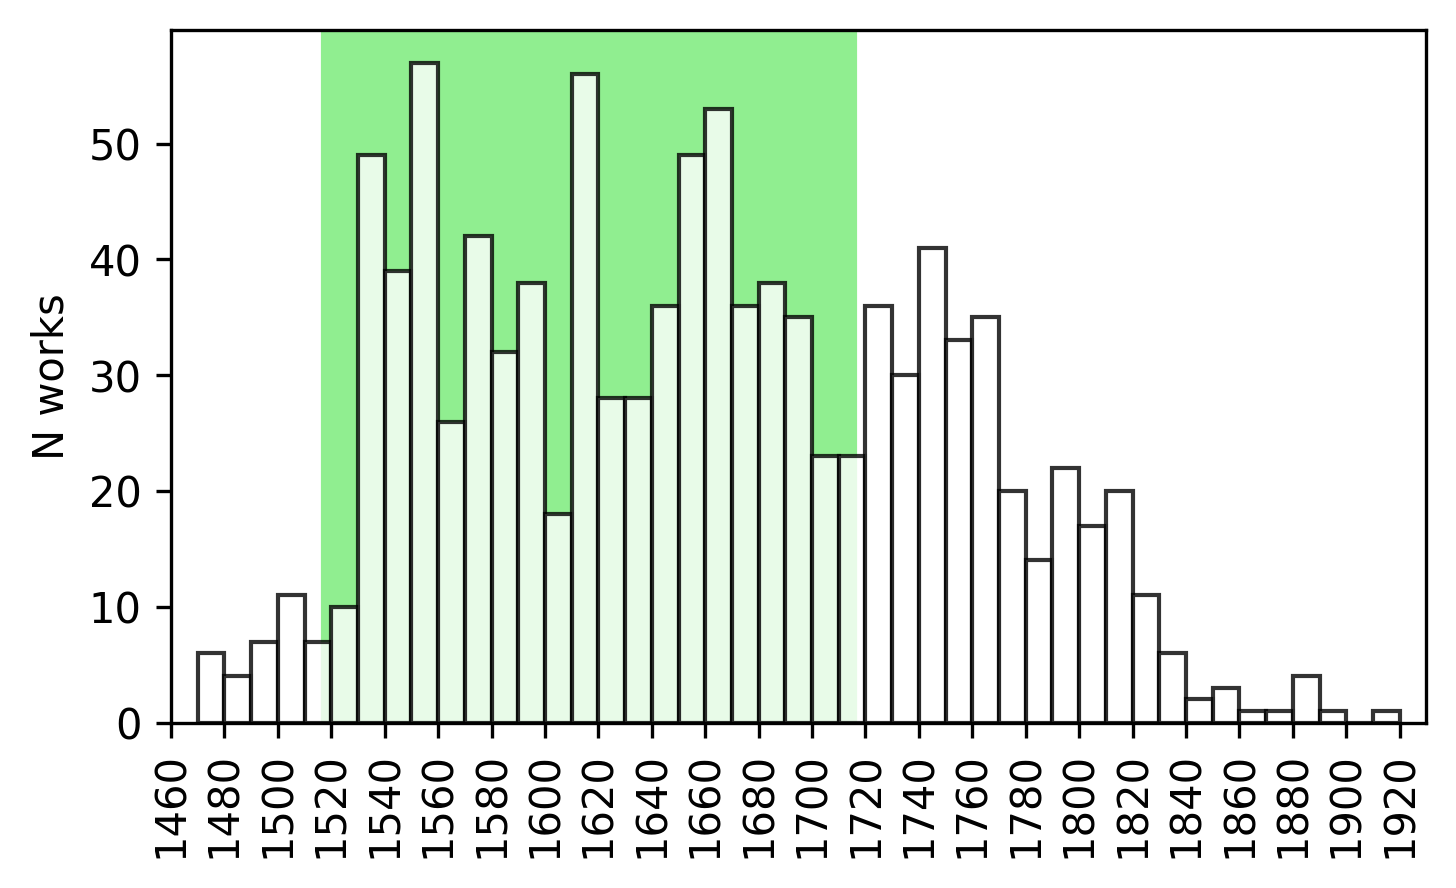

In [31]:
fig, ax = plt.subplots(figsize=(5.4, 3), dpi=300)
ax.axvspan(1517, 1716, color="lightgreen")
metadata_table_long["file_year"].plot.hist(bins=range(1470,1930,10), ec="black", color="white", alpha=0.8, ax=ax)
ax.set_xticks(range(1460,1960,20))
ax.set_xticklabels([str(n) for n in range(1460,1960,20)], rotation=90)
ax.set_ylabel("N works")
ax.set_xlim(1460, 1930)


In [ ]:
fig.savefig("../figures/noscemus_works_tempdist.png")

In [32]:
metadata_table_long.to_csv("../data/metadata_table_long.csv", index=False)

In [33]:
metadata_table_long.sort_values("Author", inplace=True)

In [206]:
set_with_dataframe(noscemus_gs.add_worksheet("metadata_table_long_v2", 1,1), metadata_table_long)

# Load & Explore Spacy Docs

In [53]:
s = sddk.cloudSession(provider="sciencedata.dk", shared_folder_name="TOME/DATA/NOSCEMUS", owner="kase@zcu.cz")

connection with shared folder established with you as its ordinary user
endpoint variable has been configured to: https://sciencedata.dk/sharingout/kase%40zcu.cz/TOME/DATA/NOSCEMUS/


In [35]:
target_folder_name = "noscemus_spacyjsons_v1"
jsonfiles_list = s.list_filenames(target_folder_name, "json")
jsonfiles_list[:10]

['1031760.json',
 '1085290.json',
 '1285853.json',
 '1285854.json',
 '1285855.json',
 '1285856.json',
 '1365811.json',
 '1370560.json',
 '1378359.json',
 '1424044.json']

In [36]:
len(jsonfiles_list)

1007

In [37]:
metadata_table_long.groupby("Form/Genre").size().sort_values(ascending=False)

Form/Genre
Monograph                                        92
Dissertation                                     71
Encyclopedic work                                51
Bibliography                                     48
Didactic poem                                    45
                                                 ..
Letter, Other (see description), Historia         1
Letter, Other (see description), Dissertation     1
Letter, Didactic poem                             1
Letter, Dialogue, Other (see description)         1
Translation, Review                               1
Length: 192, dtype: int64

In [38]:
def filename_to_doc(filename, dir=target_folder_name):
    doc_json = s.read_file(dir + "/" + filename, "dict")
    doc = Doc(nlp.vocab).from_json(doc_json)
    return doc

In [39]:
doc = filename_to_doc(jsonfiles_list[1])

In [40]:
doc_data = {}
doc_data["characters_n"] = len(doc.text)
doc_data["tokens_n"] = len([t for t in doc])

In [41]:
doc_data

{'characters_n': 2930782, 'tokens_n': 572944}

In [42]:
for ent in doc.ents[:20]:
    print(ent.text)

Georg Abraham
Lindenius
Renovatus
Medicis Lindenius
Renqvatus
Johannis
Antonidae
Linden
Catalogum
Authores
Cynosuram
Rerum
Thematum
Vitae
Adscita
Medicis
Anne
Lxii
Continuati
Norimberg


In [43]:
all_lemmata = []
for token in doc:
    all_lemmata.append((token.text, token.lemma_, token.pos_))

In [44]:
all_lemmata[200:400]

[('Ord.', 'Oard.s', 'VERB'),
 ('&', '&', 'PUNCT'),
 ('Academic', 'academic', 'VERB'),
 ('.', '.', 'PUNCT'),
 ('Curios', 'Curii', 'NOUN'),
 ('.', '.', 'PUNCT'),
 ('dict', 'dict', 'VERB'),
 ('.', '.', 'PUNCT'),
 ('Chiron', 'Chiron', 'PROPN'),
 ('.', '.', 'PUNCT'),
 ('Cum', 'cum', 'SCONJ'),
 ('Gratia', 'Gratia', 'NOUN'),
 ('&', '&', 'PUNCT'),
 ('Privilegio', 'Privilegium', 'NOUN'),
 ('S.', 'S.', ''),
 ('C.', 'C.arcus', 'PROPN'),
 ('Majest', 'Majest', 'PROPN'),
 ('.', '.', 'PUNCT'),
 ('Ooabvv', 'Ooabvv', 'NUM'),
 ('-', '-', 'PUNCT'),
 ('ii', 'is', 'NUM'),
 ('Norimbergae', 'Norimbergaa', 'PROPN'),
 (',', ',', 'PUNCT'),
 ('Impensis', 'impensis', 'NOUN'),
 ('Johannis', 'Johann', 'PROPN'),
 ('Georgii', 'Georgius', 'PROPN'),
 ('Endteri', 'Endteri', 'PROPN'),
 ('.', '.', 'PUNCT'),
 ('Anno', 'Annus', 'NOUN'),
 ('Christi', 'Christus', 'PROPN'),
 ('M.', 'M.', 'PROPN'),
 ('Dc', 'Dc', 'ADV'),
 ('.', '.', 'PUNCT'),
 ('Lxxxvi', 'Lxxxvi', 'PROPN'),
 ('.', '.', 'PUNCT'),
 ('Reverendissimo', 'Reverendissi

In [45]:
doc_lemmata = [" ".join([t.lemma_.lower() for t in sent if not t.is_punct]) for sent in doc.sents]
doc_postags = [" ".join([t.pos_ for t in sent if not t.is_punct]) for sent in doc.sents]

In [46]:
all_sents_lemmata = []
for sent in doc.sents:
    sent_lemmata = []
    for token in sent:
        #if token.pos_ in ["NOUN", "VERB", "ADJ"]:
        sent_lemmata.append((token.text, token.lemma_, token.tag_))
    all_sents_lemmata.append(sent_lemmata)

In [99]:
try:
    !mkdir ../data/large_data/sents_lemmata
    !mkdir ../data/large_data/sents_pos
except:
    pass

mkdir: ../data/large_data/sents_lemmata: File exists
mkdir: ../data/large_data/sents_pos: File exists


In [47]:
jsonfiles_list[0]

'1031760.json'

In [48]:
fn = jsonfiles_list[0]
doc = filename_to_doc(fn)

In [49]:
%%time
f_lemmata = open("../data/large_data/sents_lemmata/" + fn.replace(".json", ".txt"), "w", encoding="utf-8")
doc_lemmata = [" ".join([t.lemma_.lower() for t in sent if not t.is_punct]) for sent in doc.sents]
f_lemmata.writelines("\n".join(doc_lemmata))

f_postags = open("../data/large_data/sents_pos/" + fn.replace(".json", ".txt"), "w", encoding="utf-8")
doc_postags = [" ".join([t.pos_ for t in sent if not t.is_punct]) for sent in doc.sents]
f_postags.writelines("\n".join(doc_postags))

CPU times: user 69.3 ms, sys: 2.32 ms, total: 71.6 ms
Wall time: 72.7 ms


In [50]:
files_ready = os.listdir("../data/large_data/sents_lemmata")

In [51]:
for fn in jsonfiles_list:
    if fn.replace(".json", ".txt") not in files_ready:
        doc = filename_to_doc(fn)
        f_lemmata = open("../data/large_data/sents_lemmata/" + fn.replace(".json", ".txt"), "w", encoding="utf-8")
        doc_lemmata = [" ".join([t.lemma_.lower() for t in sent if not t.is_punct]) for sent in doc.sents]
        f_lemmata.writelines("\n".join(doc_lemmata))
        f_postags = open("../data/large_data/sents_pos/" + fn.replace(".json", ".txt"), "w", encoding="utf-8")
        doc_postags = [" ".join([t.pos_ for t in sent if not t.is_punct]) for sent in doc.sents]
        f_postags.writelines("\n".join(doc_postags))

In [56]:
# make zip archives of the text files with lemmatazed sentences and pos tags
shutil.make_archive("../data/large_data/sents_lemmata", 'zip', "../data/large_data/sents_lemmata") #
shutil.make_archive("../data/large_data/sents_pos", 'zip', "../data/large_data/sents_pos") #

'/Users/vojtechkase/Projects/noscemus_ETF/data/large_data/sents_pos.zip'

In [65]:
# upload the zip archived data to sciencedata.dk 
s.s.put("https://sciencedata.dk/sharingout/kase%40zcu.cz/TOME/DATA/NOSCEMUS/sents_lemmata.zip", data=open("../data/large_data/sents_lemmata.zip", "rb"))
s.s.put("https://sciencedata.dk/sharingout/kase%40zcu.cz/TOME/DATA/NOSCEMUS/sents_pos.zip", data=open("../data/large_data/sents_pos.zip", "rb"))

<Response [201]>

# Preliminary explorations of Latin wordnet

In [138]:
latinwn = pd.read_csv("https://raw.githubusercontent.com/CIRCSE/latinWordnet-revision/master/LiLa_LatinWordnet.csv")

In [139]:
latinwn.head(5)

,id,lemma,type,lila_uri,id_synset,definition
0,90942,"a, aa",LEMMA,http://lila-erc.eu/data/id/lemma/90942,http://wordnet-rdf.princeton.edu/wn30/06831177-n,the 1st letter of the Roman alphabet
1,86826,abactio,LEMMA,http://lila-erc.eu/data/id/lemma/86826,http://wordnet-rdf.princeton.edu/wn30/00391599-n,the act of removing
2,86828,abactor,LEMMA,http://lila-erc.eu/data/id/lemma/86828,http://wordnet-rdf.princeton.edu/wn30/10544480-n,someone who steals livestock (especially cattle)
3,91165,abactus,LEMMA,http://lila-erc.eu/data/id/lemma/91165,http://wordnet-rdf.princeton.edu/wn30/00780889-n,the act of taking something from someone unlaw...
4,86833,abaculus,LEMMA,http://lila-erc.eu/data/id/lemma/86833,http://wordnet-rdf.princeton.edu/wn30/04435180-n,a flat thin rectangular slab (as of fired clay...
